# **A/B testing KKBOX churn rate**

### **About**

*In this project we implement A/B testing techniques using `Frequentist` approach and `Bayesian` approach to test the significance
of churn rate mong two group of music listeners*

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

### **Data**

*We are using dataset donated by `KKBOX`. The company offers subscription based music service. Since the subscription is renewed 
every month. It is importnt to know if the customer churn after a certain period of time. The data consist of `user_logs` and the 
customer `churn` rate*

In [52]:
logs = pd.read_csv("user_logs_v2.csv", usecols=["msno", "total_secs"])

In [53]:
churn = pd.read_csv("train_v2.csv")

### **Objective**

*Our objective is to test the significance of music listeners who spent `more than mean` time and `less than mean` time on playing 
the music and test if the two groups of the music listeners is siginificantly `different` from each other in there respective
`churn rate`* 

### **Data Processing**

*From `user_logs` we will sum all the seconds of every unique customer and get the total seconds its spends on playing the 
music every month*

In [54]:
logs = logs.groupby("msno").sum()

*We will join the two datasets (log_userv2 and train_v2) to observe of the users churn away based on there listening time*

In [55]:
df = logs.merge(churn, how="inner", on="msno")

In [56]:
del churn, logs

*Then we convert the total_seconds to `hours`*

In [57]:
df["total_secs"] = df["total_secs"]/(60*60)

*Caluclating the mean time of all users*

In [58]:
mean_time = df["total_secs"].mean()

*Seprating users based on `more_than_mean` and `less_than_mean` value*

In [59]:
df["mean_time"] = df["total_secs"] > mean_time

In [60]:
more_than_mean = df[df["mean_time"] == True].sample(100000)

In [61]:
less_than_mean = df[df["mean_time"] == False].sample(100000)

### **Frequentist Approach** 

*In the frequentist approach we establish the significance of data based on given model and verify the result using the probability 
assosiated with the difference in the means of two groups. In this method first we calulate the sample size for our test*

### **Sample Size**

In [62]:
pop = []
p1 = []
for i in range(1,2000):
    postives = float(more_than_mean["is_churn"].sample(i*50).sum())
    p1.append(postives/(i*50))
    pop.append(i*50)

In [63]:
p2 = []
for i in range(1,2000):
    postives = float(less_than_mean["is_churn"].sample(i*50).sum())
    p2.append(postives/(i*50))

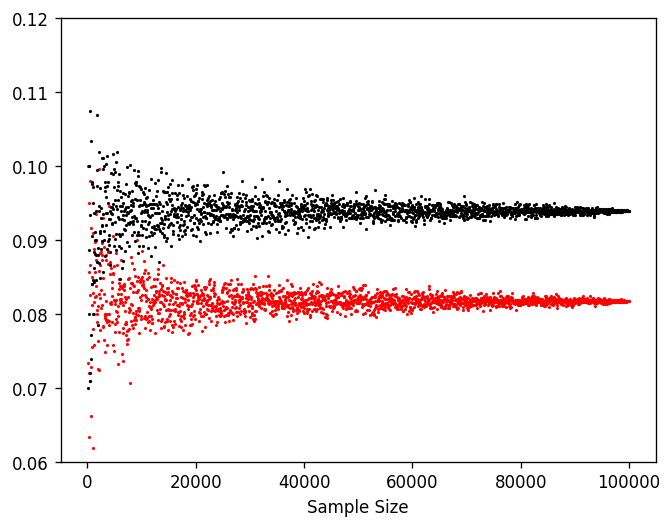

In [64]:
plt.figure(dpi=120)
plt.scatter(x=pop, y=p1, s=0.8, color="red")
plt.scatter(x=pop, y=p2, s=0.8, color="black")
plt.xlabel("Sample Size")
plt.ylim(0.06, 0.12);

We calculate the sample size using the margin of error concept. We calculated the margin of error using the formulae

$$MOE=\ z\times \sqrt\frac{p(1-p)}{n}$$<br>
$z$ =  *for 95% confidence*<br>
$MOE$ = *margin of error*<br>
$p$ = *observed proportion* (if not given assume to be 0.5)<br>
$n$ = *Sample Size*<br>

In [65]:
def sample_size(z, p, error):
    n = (z**2) * ((p*(1-p))/(error**2))
    return np.ceil(n)

In [66]:
# for margen of error = 0.005%
# z = 1.96
# p is unknown (0.5)
sample_size(1.96, 0.5, 0.005)

38416.0

*We choose the sample size of 100000 for both groups*

### **Formulate the Hypothesis**

***p1** = proportion of listners who plays less_then_mean*<br>
***p2** = proportion of listners who plays more_then_mean*<br>

*$H_0$ : the churn rate for listeners who plays more than mean is not different than the listeners who plays less than the 
mean_time*<br> 
*(p1-p2 = 0)*<br>
*$H_A$ : the churn rate for listeners who plays more than mean is different than the listeners who plays less than the 
mean_time*<br>
*(p1-p2 != 0)*

In [67]:
# proportions
def prop(freq):
    churn = freq.sum()
    total = len(freq)
    return churn/total

In [68]:
p1 = prop(less_than_mean["is_churn"])
p2 = prop(more_than_mean["is_churn"])

In [69]:
p1p2 = p1 - p2
print(p1p2)

0.012209999999999999


### **Test Normality assumption**

*Before testing the hypothesis we have to make sure tht distribution of p1-p2 follows normal distribution. In order to test it 
we to prove two assumptions to be true*

1. *Independence within and between the group*
2. *Test the success-failure condition*

*Since we are testing p1-p2=0 we need to calculate pooled proportions using formulae*

$$p_{pooled} = \frac{(n_1p_1 + n_2p_2)}{n_1 + n_2}$$

In [70]:
def pooled_prop(s1, s2):
    pool =  (s1.sum() + s2.sum())/(len(s1) + len(s2))
    return pool

In [71]:
ppool = pooled_prop(less_than_mean["is_churn"], more_than_mean["is_churn"])
print(ppool)

0.087815


*For **Success -Failure condition** to be true*

$n_1p_{pooled} > 10$<br>
$n_1(1-p_{pooled}) > 10$<br>
$n_2p_{pooled} > 10$<br>
$n_2(1-p_{pooled)} > 10$<br>

In [72]:
def sfcondition(p, s1, s2):
    a = []
    a.append(p * len(s1))
    a.append(p * len(s2))
    a.append((1-p) * len(s1))
    a.append((1-p) * len(s1))
    a = np.array(a) > 10 
    return np.all(a)

In [73]:
sfcondition(ppool, less_than_mean["is_churn"], more_than_mean["is_churn"])

True

### **Calculate the test static z**

*Standard Error pooled*
$$SE_{pooled} = \sqrt\frac{p_{pooled}(1-p_{pooled})}{n_1} + \frac{p_{pooled}(1-p_{pooled})}{n_2}$$

In [74]:
def se_pooled(p, s1, s2):
    x1 = (p*(1-p))/(len(s1))
    x2 = (p*(1-p))/(len(s2))
    se = np.sqrt(x1 + x2)
    return se

In [75]:
sepool = se_pooled(ppool, less_than_mean["is_churn"], more_than_mean["is_churn"])
print(sepool)

0.0012657292425712538


In [76]:
def z_static(x, p, se):
    z = (x - p) / se
    return z

In [77]:
z_value = z_static(p1p2, 0, sepool)
print(z_value)

9.646612868954586


### **Calculate two tailed probability**

In [78]:
from scipy import stats

In [79]:
p_value = stats.norm.sf(z_value) 
print(2 *p_value)

5.080614878532172e-22


### **Test the value against $\alpha$ level of significance**

In [80]:
# two tailed test
2 * p_value  > 0.05

False

*Therefore we reject the Null Hypothesis and accept the Alternted Hypothesis, there is significant difference 
between the churn rate of listeners who  play more than mean and less than mean hours*

### **Permutation Test Method**

*In permutation approach there is no need to test the assumption of normality because we generate the null distribution using
random shuffling of the samples*

*Null distribution is generated using shuffling the bag of samples and drawing the samples from group A and group B without replacement and record the test static for each permutation. We repeat the process to get a smooth Null Hypothesis distribution*

In [81]:
bag = pd.concat([more_than_mean["is_churn"], less_than_mean["is_churn"]])

In [82]:
p1p2_random =  []
n_perm = 100000
for i in range(1000):
    x = bag.sample(frac=1)
    a = x[:100000].sum()
    b = x[100000:].sum()
    p1 = a/100000
    p2 = b/100000
    diff = p1 - p2
    p1p2_random.append(diff)

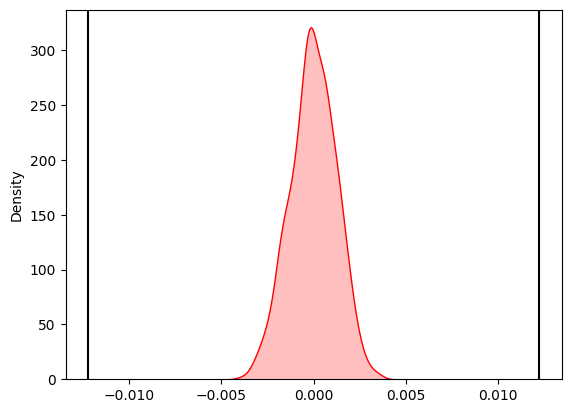

In [83]:
sns.kdeplot(data=p1p2_random, color="red", fill=True)
plt.axvline(p1p2,color="black")
plt.axvline((-1*p1p2),color="black");

*We test the hypothesis by adding all p values which are greater than or equal to p1-p2, i.e. values that are as or more extreme
than the observe value*

In [84]:
print(max(p1p2_random))
print(min(p1p2_random))
print(p1p2)

0.003610000000000002
-0.003949999999999995
0.012209999999999999


*We test this p value against the significance level and decide wether to retain or reject the Null hypothesis*

*since the value are know close to the p1p2 threshold we assume probability to be approximately 0* 

In [85]:
0.0 > 0.05

False

*Therefore we reject the Null Hypothesis and accept the Alternted Hypothesis, there is significant difference 
between the churn rate of listeners who  play more than mean and less than mean hours*

### **Bayesian Approach**

*In Bayesian method we take into account the uncertainity assosiated with the model. In Bayesian approach we calculate the model
based on the given data which incorporate uncertainity within model for each piece of additional information.*

*For the sake of performing bayesian AB testing we will seprate 100000 samples from each group of more_than_mean and 
less_thn_mean and pretend this data to have not been seen before*

### **Calculating Prior** 

*Genrating prior distribution for each group*

In [116]:
prior = df[~((df["msno"].isin(more_than_mean)) | (df["msno"].isin(less_than_mean)))]

In [117]:
prior_more = []
for i in range(1000):
    mean = prior[prior["mean_time"] == True]["is_churn"].sample(1000).mean()
    prior_more.append(mean)

In [118]:
prior_less = []
for i in range(1000):
    mean = prior[prior["mean_time"] == False]["is_churn"].sample(1000).mean()
    prior_less.append(mean)

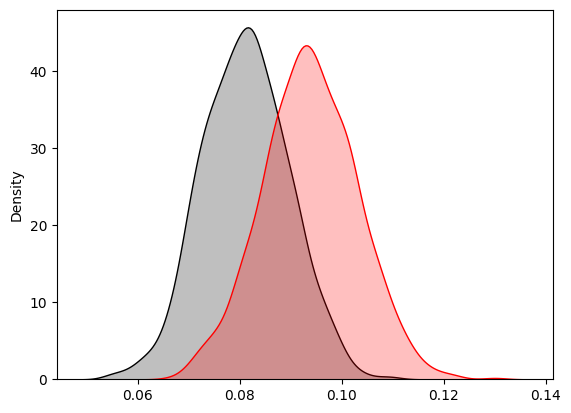

In [119]:
sns.kdeplot(data=prior_more, color="black" ,fill=True, label="more_than_mean")
sns.kdeplot(data=prior_less, color="red", fill=True, label="less_than_mean");

*Now first we calculate prior distribution by fitting data from prior and using beta distribution to calculate alpha and 
beta value for both the groups*

In [120]:
# fit the beta distribution 
from scipy import stats

In [121]:
beta_more = stats.beta.fit(prior_more, floc=0, fscale=1)
beta_more_alpha = beta_more[0]
beta_more_beta = beta_more[1]

In [122]:
beta_less = stats.beta.fit(prior_less, floc=0, fscale=1)
beta_less_alpha = beta_less[0]
beta_less_beta = beta_more[1]

*From the distribution of both groups we can observe both have high uncertainity*

In [123]:
prior_distribution_more = stats.beta(beta_more_alpha, beta_more_beta).rvs(1000)
prior_distribution_less = stats.beta(beta_less_alpha, beta_less_beta).rvs(1000)

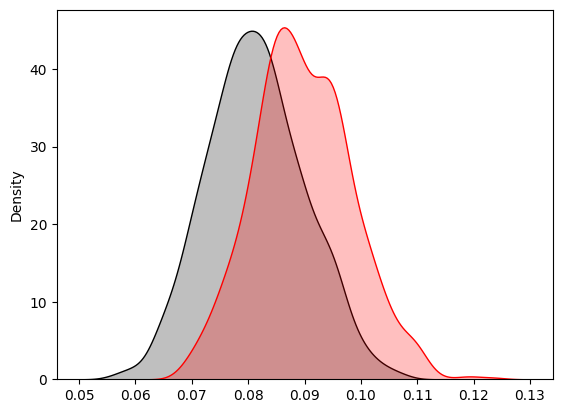

In [124]:
sns.kdeplot(data=prior_distribution_more, color="black", fill=True, label="more_than_mean")
sns.kdeplot(data=prior_distribution_less, color="red", fill=True, label="less_than_mean");

*Now we will introduce new users churn information into the beta distributions to see how parametersand posterior are updated
and how two startegies perform in comparison to each other in long term (100 step with data of 1000 new users in each step)*

In [125]:
prob = []
start = 0
end = 1000
batch_size = 1000
prior_alpha_more = beta_more_alpha
prior_beta_more = beta_more_beta
prior_alpha_less = beta_less_alpha
prior_beta_less = beta_less_beta

for i in range(100):
    more_churn = more_than_mean.iloc[start:end, 2].sum()
    more_not_churn = 1000 - more_churn
    less_churn = less_than_mean.iloc[start:end, 2].sum()
    less_not_churn = 1000 - less_churn
    
    posterior_more = stats.beta(prior_alpha_more + more_churn, prior_beta_more + more_not_churn)
    posterior_less = stats.beta(prior_alpha_less + less_churn, prior_beta_less + less_not_churn)
    more_sample = posterior_more.rvs(1000)
    less_sample = posterior_less.rvs(1000)
    p = np.mean(less_sample > more_sample)
    prob.append(p)
    
    prior_alpha_more = prior_alpha_more + more_churn
    prior_beta_more = prior_beta_more + more_not_churn
    prior_alpha_less = prior_alpha_less + less_churn
    prior_beta_less = prior_beta_less + less_not_churn
    start = start + batch_size
    end = end + batch_size

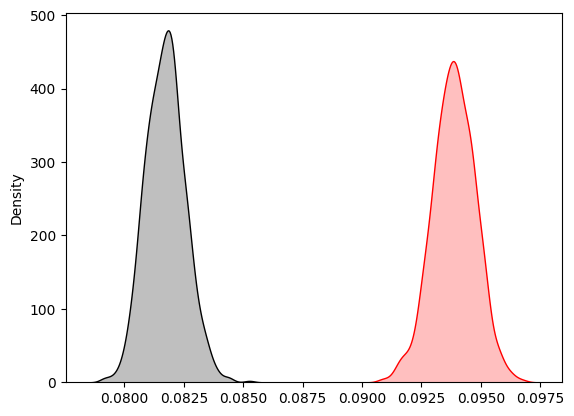

In [126]:
sns.kdeplot(data=more_sample, color="black", fill=True, label="more_than_mean")
sns.kdeplot(data=less_sample, color="red", fill=True, label="less_than_mean");

*After 100 rounds of observation we can clearly see that strategy of more_than_mean work less_than_mean  99.99% of time*

In [127]:
sample_size = np.arange(0, 100000, step=1000)

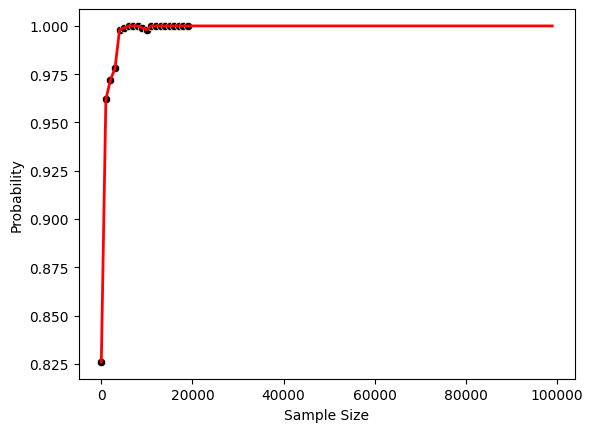

In [128]:
ax = sns.scatterplot(x=sample_size[:20], y=prob[:20], color="black")
sns.lineplot(x=sample_size, y=prob, color="red", linewidth=2.0)
ax.set_xlabel("Sample Size")
ax.set_ylabel("Probability");